# Credit Card Fraud Detection


# Setup 



In [1]:
# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Mutual information and feature selection
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.metrics import mutual_info_score

# Statistical computations (optional for advanced use cases)
from scipy.stats import entropy

# Handling imbalanced data
from imblearn.ensemble import BalancedRandomForestClassifier

# Model explainability
from alibi.explainers.ale import ALE, plot_ale
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Permutation Importance
from sklearn.inspection import permutation_importance

# SHAP Values
import shap

# Suppress FutureWarnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# Widgets is required for some libraries. Verfiy Installation.
import ipywidgets as widgets

print(widgets.__version__)

8.1.2


## Reading in files 


In [3]:
# Read in the Data
folder_path = "./data/"
train_identity = pd.read_csv(f"{folder_path}train_identity.csv")
train_transaction = pd.read_csv(f"{folder_path}train_transaction.csv")
test_identity = pd.read_csv(f"{folder_path}test_identity.csv")
test_transaction = pd.read_csv(f"{folder_path}test_transaction.csv")

## Combining respective datasets

In [4]:
# Combine the datasets
train = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")
test = pd.merge(test_transaction, test_identity, on="TransactionID", how="left")

# Replace inf and -inf values with NaN in the dataset
train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Exploratory Data Analysis

In [5]:
# Print train dataset summaries
print(
    f"Train transaction dataset has {train_transaction.shape[0]} rows and {train_transaction.shape[1]} columns."
)
print(
    f"Train identity dataset has {train_identity.shape[0]} rows and {train_identity.shape[1]} columns."
)
print(f"Merged Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.")

# Display the first few rows of the merged train dataset
print("\nFirst 5 rows of the Merged Train dataset:")
train.head()

Train transaction dataset has 590540 rows and 394 columns.
Train identity dataset has 144233 rows and 41 columns.
Merged Train dataset has 590540 rows and 434 columns.

First 5 rows of the Merged Train dataset:


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
# Print test dataset summaries
print(
    f"\nTest transaction dataset has {test_transaction.shape[0]} rows and {test_transaction.shape[1]} columns."
)
print(
    f"Test identity dataset has {test_identity.shape[0]} rows and {test_identity.shape[1]} columns."
)
print(f"Merged Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.")

# Display the first few rows of the merged test dataset
print("\nFirst 5 rows of the Merged Test dataset:")
test.head()


Test transaction dataset has 506691 rows and 393 columns.
Test identity dataset has 141907 rows and 41 columns.
Merged Test dataset has 506691 rows and 433 columns.

First 5 rows of the Merged Test dataset:


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plots of Select Categorical Variables

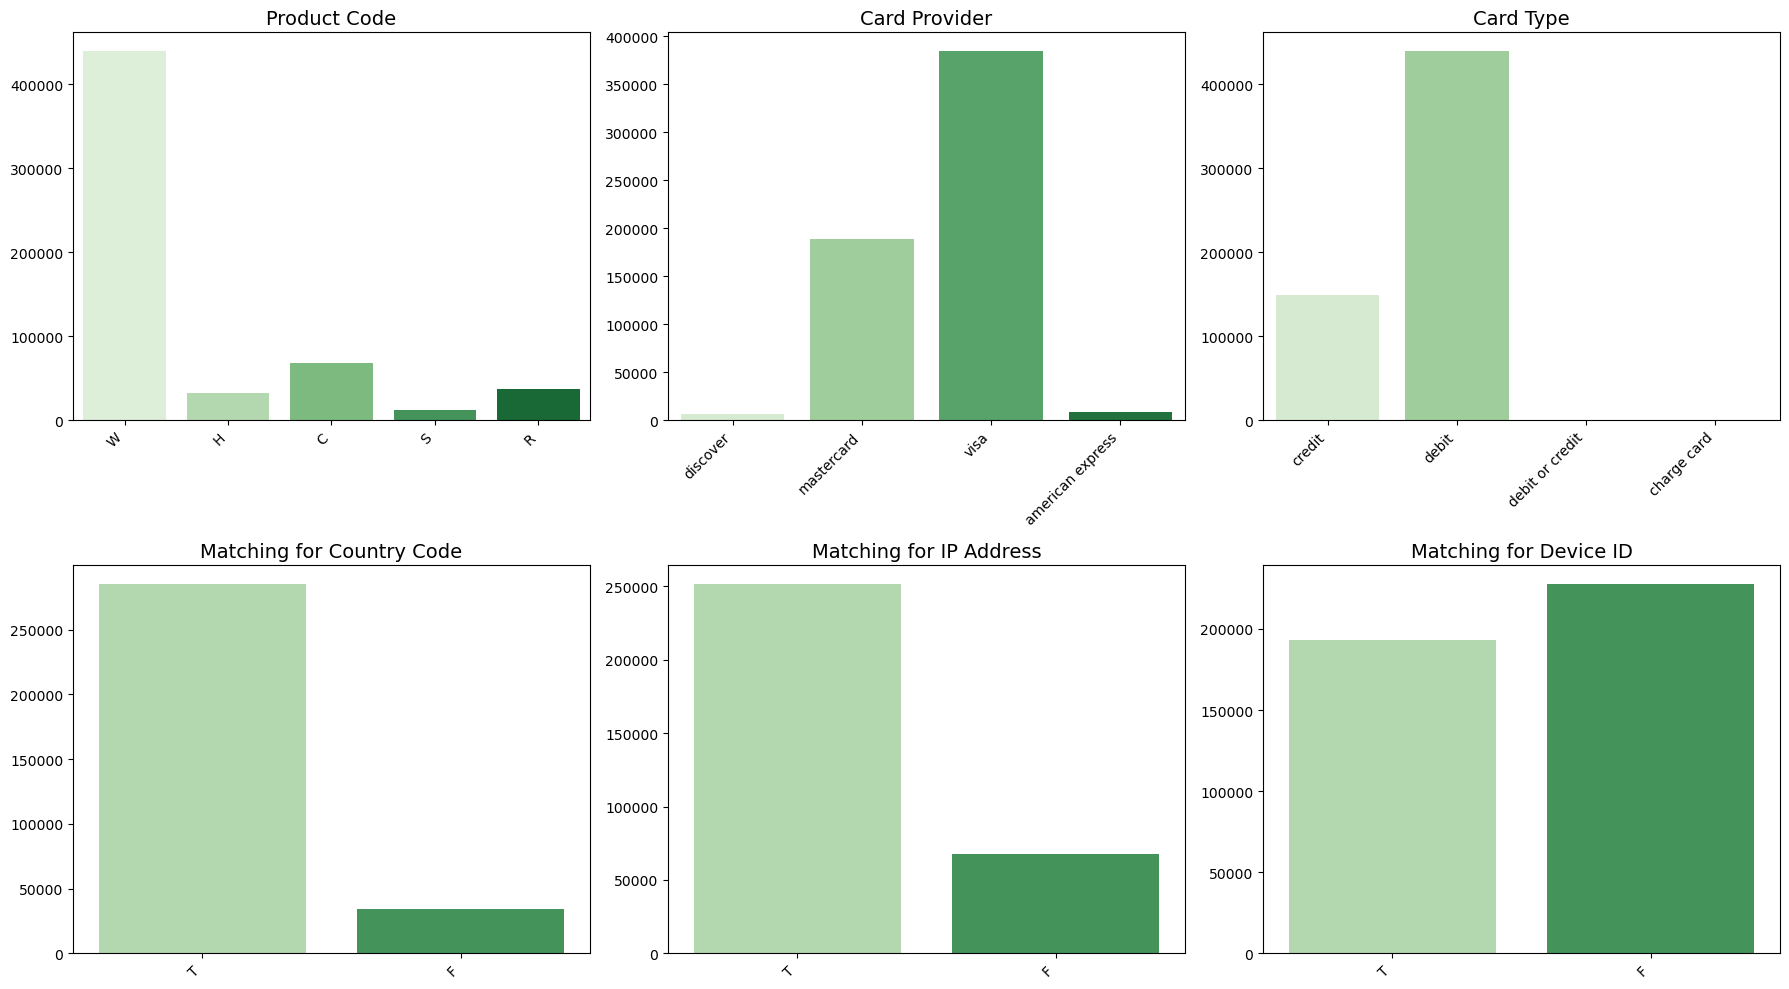

In [7]:
# List of categorical features to plot
features = ["ProductCD", "card4", "card6", "M2", "M3", "M6"]

# List of names for each feature (match order with features list)
names = [
    "Product Code",
    "Card Provider",
    "Card Type",
    "Matching for Country Code",
    "Matching for IP Address",
    "Matching for Device ID",
]

# Set the figure size
plt.figure(figsize=(18, 10))  # Adjust dimensions to fit the layout

# Create subplots
for i, (feature, name) in enumerate(zip(features, names), 1):
    plt.subplot(2, 3, i)  # Arrange in 2 rows and 3 columns
    sns.countplot(data=train, x=feature, palette="Greens")
    plt.title(name, fontsize=14)  # Use descriptive names with larger font size
    plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotate and align x-tick labels
    plt.xlabel("")  # Remove default x-axis label
    plt.ylabel("")  # Remove default y-axis label

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Fraud Transactions vs Days of the Week

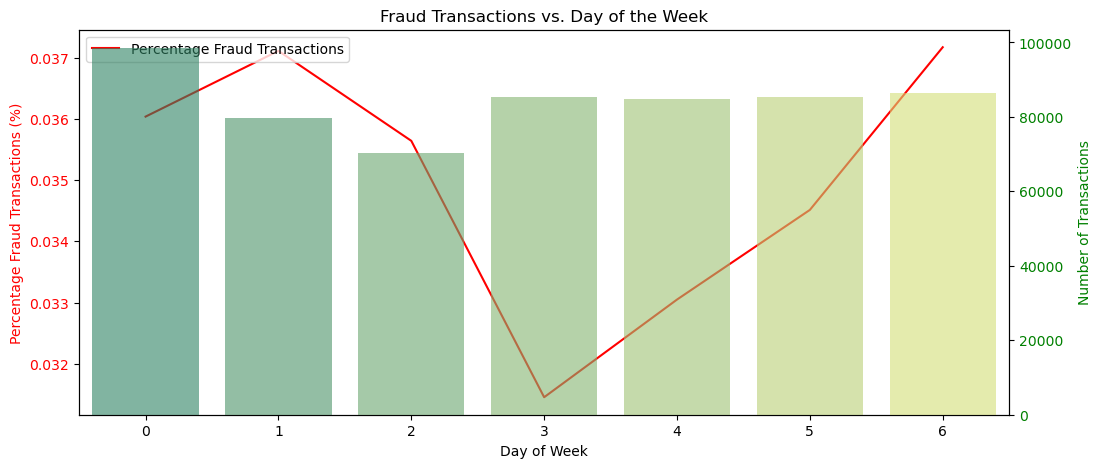

In [8]:
# Replace inf and -inf values with NaN across the entire DataFrame
train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Optional: Handle NaN values after replacing infinities (if necessary)
# For example, fill with 0 or another placeholder:
# train.fillna(0, inplace=True)

# Calculate the day of the week from TransactionDT
train["dayofweek"] = ((train["TransactionDT"] // (60 * 60 * 24)) - 1) % 7

# Calculate the percentage of fraud transactions by day of the week
tmp = (
    train[["isFraud", "dayofweek"]]
    .groupby(by=["dayofweek"])
    .mean()
    .reset_index()
    .rename(columns={"isFraud": "Percentage fraud transactions"})
)

# Calculate the total number of transactions by day of the week
tmp_count = (
    train[["TransactionID", "dayofweek"]]
    .groupby(by=["dayofweek"])
    .count()
    .reset_index()
    .rename(columns={"TransactionID": "Number of transactions"})
)

# Merge the two summaries
tmp = tmp.merge(tmp_count, on=["dayofweek"])

# Create the figure and axes for the plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot percentage of fraud transactions as a line plot
sns.lineplot(
    data=tmp,
    x="dayofweek",
    y="Percentage fraud transactions",
    color="r",
    ax=ax1,
    label="Percentage Fraud Transactions",
)
ax1.set_ylabel("Percentage Fraud Transactions (%)", color="r")
ax1.set_xlabel("Day of Week")
ax1.tick_params(axis="y", labelcolor="r")
ax1.set_title("Fraud Transactions vs. Day of the Week")

# Create a second y-axis for the number of transactions
ax2 = ax1.twinx()
sns.barplot(
    data=tmp,
    x="dayofweek",
    y="Number of transactions",
    palette="summer",
    alpha=0.6,
    ax=ax2,
)
ax2.set_ylabel("Number of Transactions", color="g")
ax2.tick_params(axis="y", labelcolor="g")

# Add legends
ax1.legend(loc="upper left")
plt.show()

## Fraud Transaction and Total Transaction by Hour

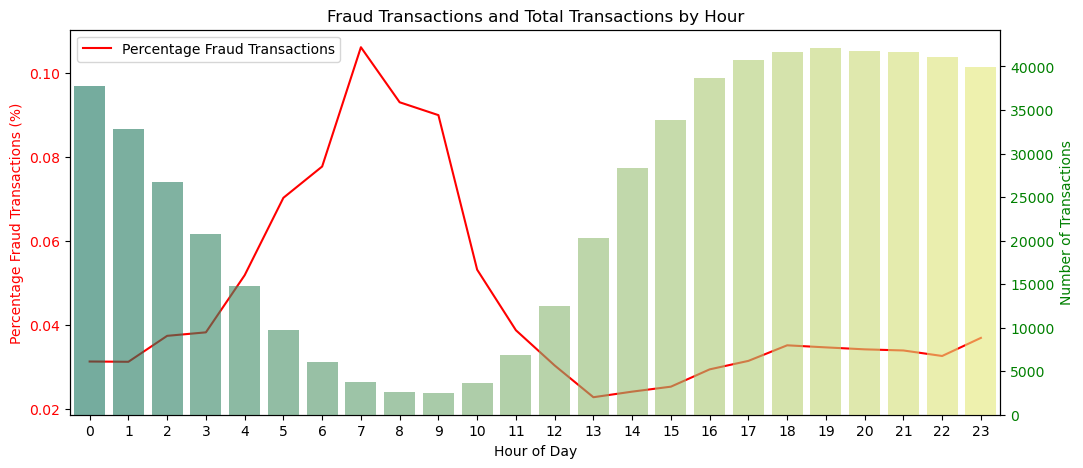

In [9]:
# Extract the hour from TransactionDT
train["hour"] = (train["TransactionDT"] // (60 * 60)) % 24

# Calculate the percentage of fraud transactions by hour
tmp = (
    train[["isFraud", "hour"]]
    .groupby(by=["hour"])
    .mean()
    .reset_index()
    .rename(columns={"isFraud": "Percentage fraud transactions"})
)

# Calculate the total number of transactions by hour
tmp_count = (
    train[["TransactionID", "hour"]]
    .groupby(by=["hour"])
    .count()
    .reset_index()
    .rename(columns={"TransactionID": "Number of transactions"})
)

# Merge the two summaries into one dataframe
tmp = tmp.merge(tmp_count, on=["hour"])

# Create the figure and axes for the plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot percentage of fraud transactions as a line plot
sns.lineplot(
    data=tmp,
    x="hour",
    y="Percentage fraud transactions",
    color="r",
    ax=ax1,
    label="Percentage Fraud Transactions",
)
ax1.set_ylabel("Percentage Fraud Transactions (%)", color="r")
ax1.set_xlabel("Hour of Day")
ax1.tick_params(axis="y", labelcolor="r")
ax1.set_title("Fraud Transactions and Total Transactions by Hour")

# Create a second y-axis for the number of transactions
ax2 = ax1.twinx()
sns.barplot(
    data=tmp,
    x="hour",
    y="Number of transactions",
    palette="summer",
    alpha=0.6,
    ax=ax2,
)
ax2.set_ylabel("Number of Transactions", color="g")
ax2.tick_params(axis="y", labelcolor="g")

# Add legends
ax1.legend(loc="upper left")
plt.show()

## Log(Transaction) Distribution - Training Data

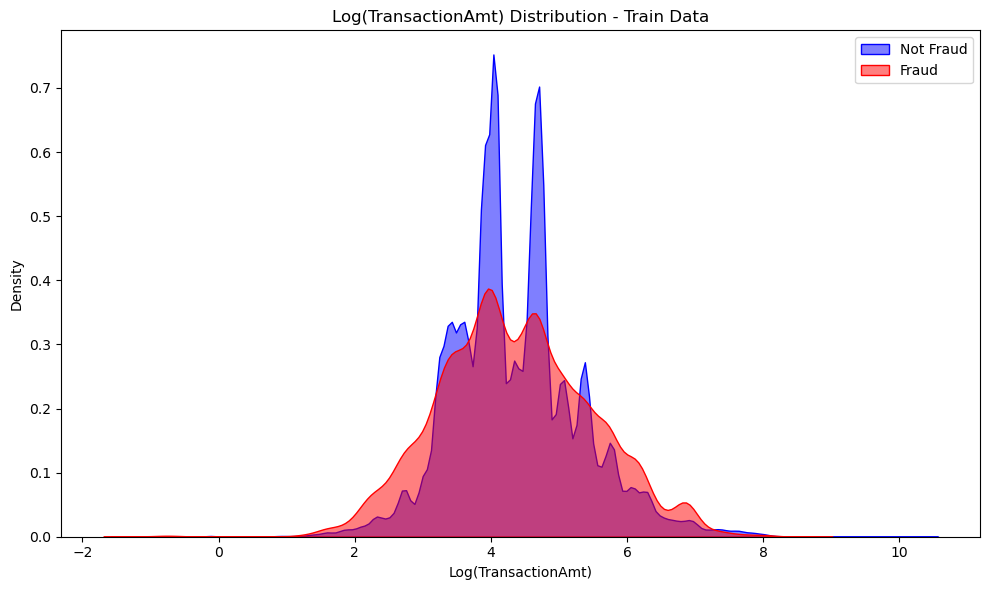

In [10]:
# Create separate dataframes for fraud and non-fraud
dff_fraud = train[
    train["isFraud"] == 1
].copy()  # Use .copy() to avoid modifying the original data
dff_notfraud = train[train["isFraud"] == 0].copy()

# Apply log transformation to TransactionAmt, avoiding errors with zero or negative values
dff_fraud["TransactionAmt"] = np.log(dff_fraud["TransactionAmt"].replace(0, np.nan))
dff_notfraud["TransactionAmt"] = np.log(
    dff_notfraud["TransactionAmt"].replace(0, np.nan)
)

# Plot distribution
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=dff_notfraud,
    x="TransactionAmt",
    label="Not Fraud",
    color="blue",
    fill=True,
    alpha=0.5,
)
sns.kdeplot(
    data=dff_fraud,
    x="TransactionAmt",
    label="Fraud",
    color="red",
    fill=True,
    alpha=0.5,
)

plt.title("Log(TransactionAmt) Distribution - Train Data")
plt.xlabel("Log(TransactionAmt)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Aggregated Feature Importance Analysis


### Processing Section 1 ###
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92     19852
           1       0.13      0.79      0.22       512

    accuracy                           0.86     20364
   macro avg       0.56      0.83      0.57     20364
weighted avg       0.97      0.86      0.90     20364

Confusion Matrix:
 [[17082  2770]
 [  106   406]]
ROC AUC Score: 0.9003783761554252


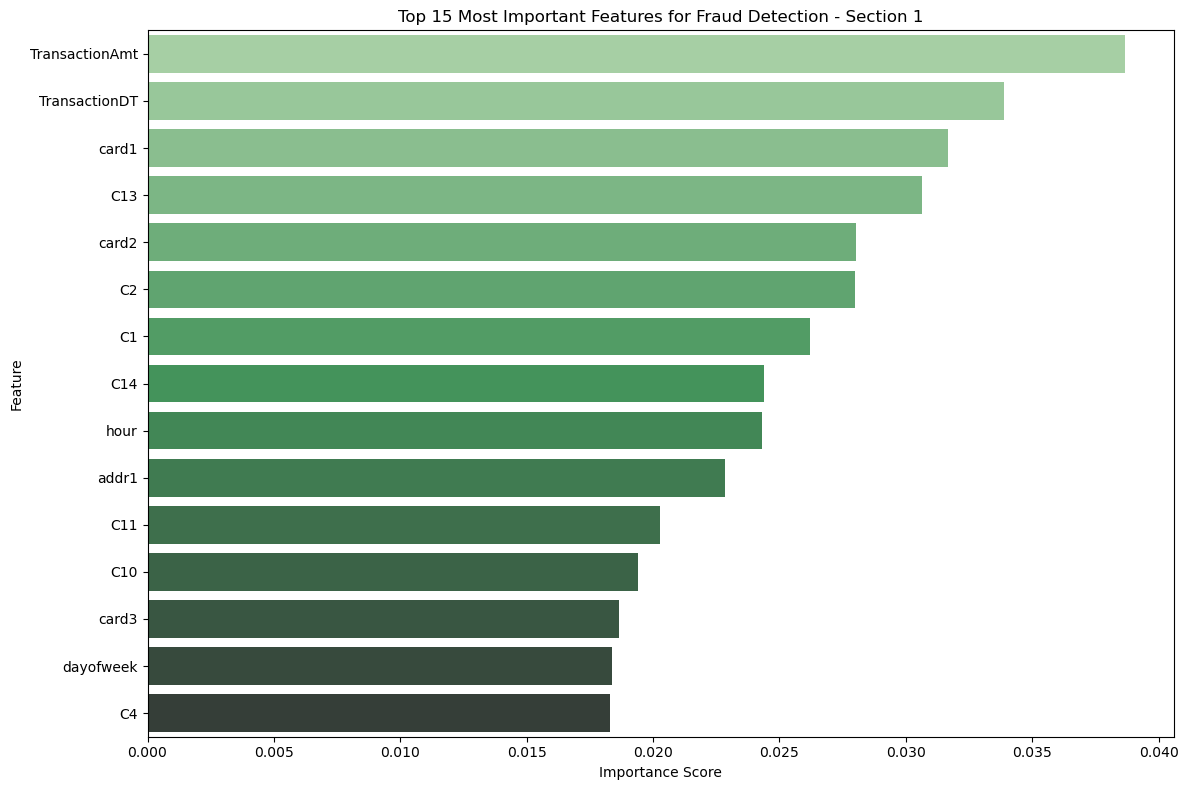

Top Features - Section 1:
             feature  importance
1    TransactionAmt    0.038662
0     TransactionDT    0.033868
2             card1    0.031657
20              C13    0.030625
3             card2    0.028023
9                C2    0.027990
8                C1    0.026216
21              C14    0.024377
177            hour    0.024318
6             addr1    0.022830
18              C11    0.020286
17              C10    0.019384
4             card3    0.018639
176       dayofweek    0.018386
11               C4    0.018285

### Processing Section 2 ###
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92     19848
           1       0.13      0.80      0.22       516

    accuracy                           0.86     20364
   macro avg       0.56      0.83      0.57     20364
weighted avg       0.97      0.86      0.90     20364

Confusion Matrix:
 [[17055  2793]
 [  104   412]]
ROC AUC Score: 0.9006922572793

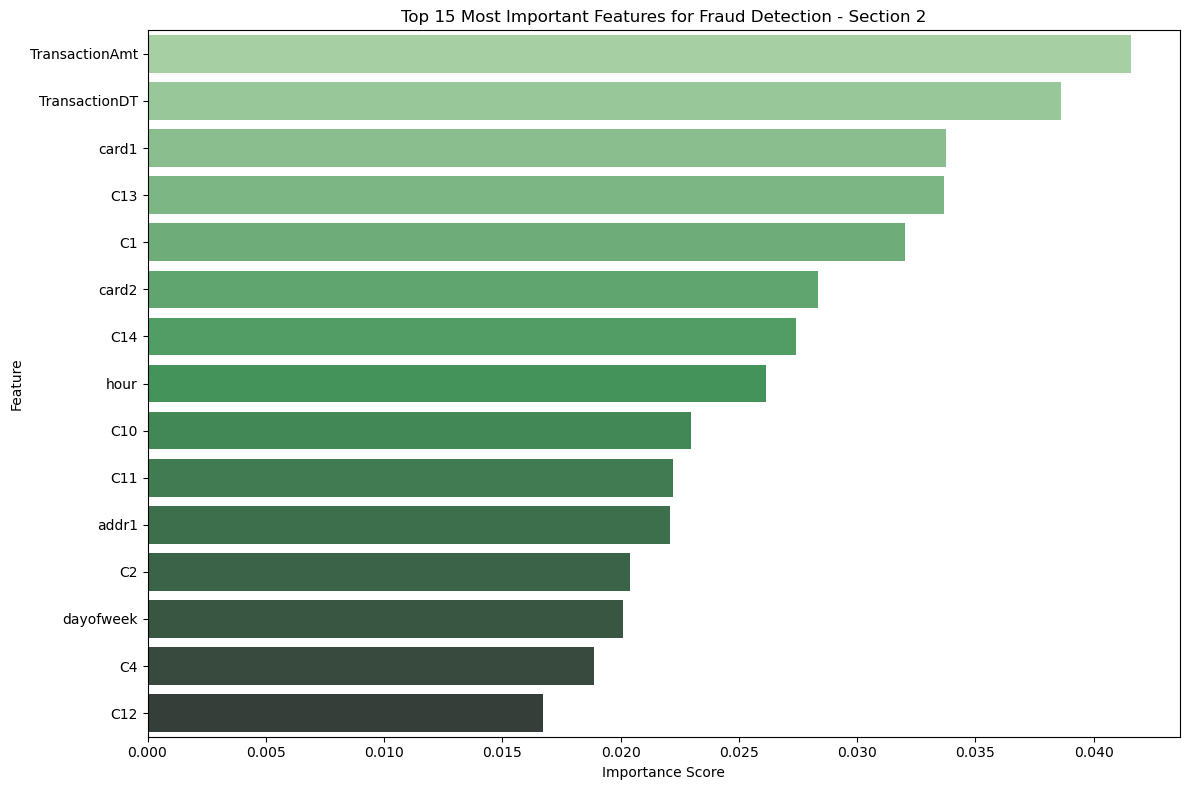

Top Features - Section 2:
             feature  importance
1    TransactionAmt    0.041567
0     TransactionDT    0.038614
2             card1    0.033741
20              C13    0.033681
8                C1    0.032016
3             card2    0.028349
21              C14    0.027420
177            hour    0.026163
17              C10    0.022974
18              C11    0.022204
6             addr1    0.022072
9                C2    0.020392
176       dayofweek    0.020103
11               C4    0.018890
19              C12    0.016728

### Processing Section 3 ###
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93     19762
           1       0.16      0.81      0.27       602

    accuracy                           0.87     20364
   macro avg       0.58      0.84      0.60     20364
weighted avg       0.97      0.87      0.91     20364

Confusion Matrix:
 [[17234  2528]
 [  116   486]]
ROC AUC Score: 0.9057587618238

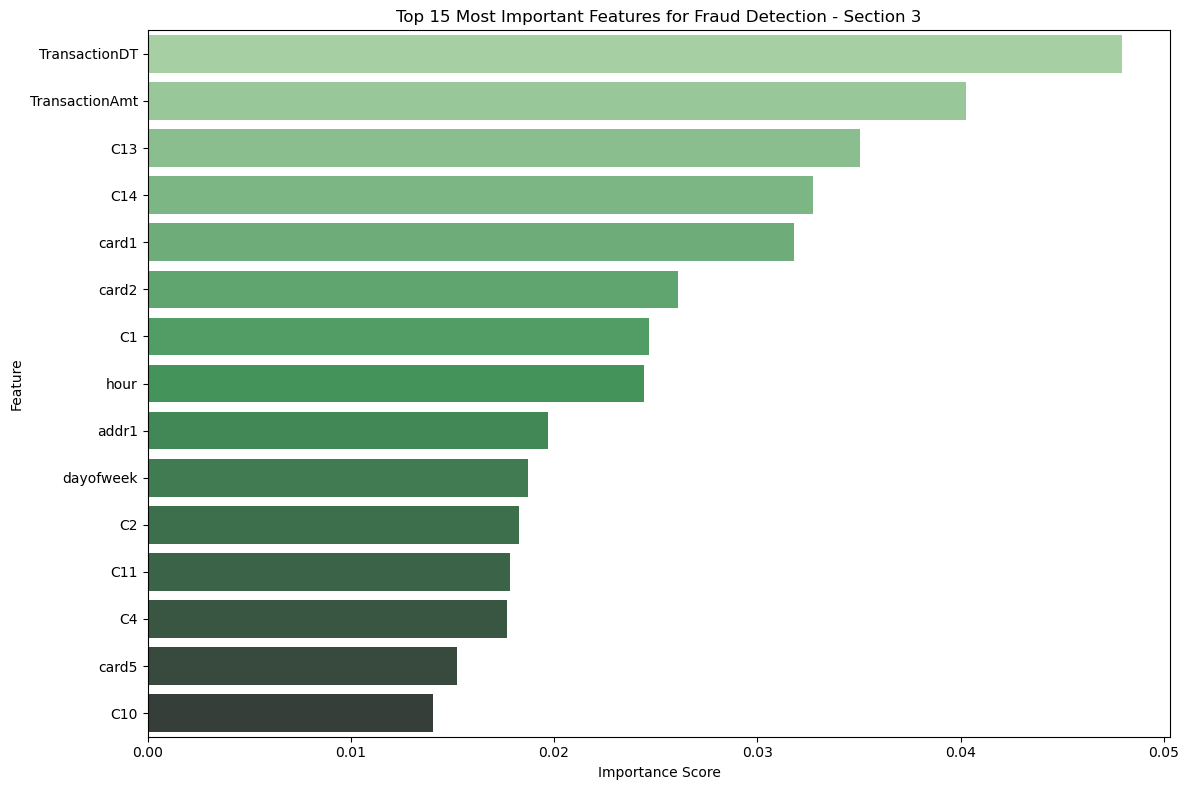

Top Features - Section 3:
             feature  importance
0     TransactionDT    0.047922
1    TransactionAmt    0.040286
20              C13    0.035031
21              C14    0.032730
2             card1    0.031819
3             card2    0.026083
8                C1    0.024689
177            hour    0.024440
6             addr1    0.019719
176       dayofweek    0.018725
9                C2    0.018279
18              C11    0.017854
11               C4    0.017696
5             card5    0.015235
17              C10    0.014055

### Processing Section 4 ###
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93     19568
           1       0.22      0.80      0.34       796

    accuracy                           0.88     20364
   macro avg       0.61      0.84      0.64     20364
weighted avg       0.96      0.88      0.91     20364

Confusion Matrix:
 [[17314  2254]
 [  162   634]]
ROC AUC Score: 0.9123093364409

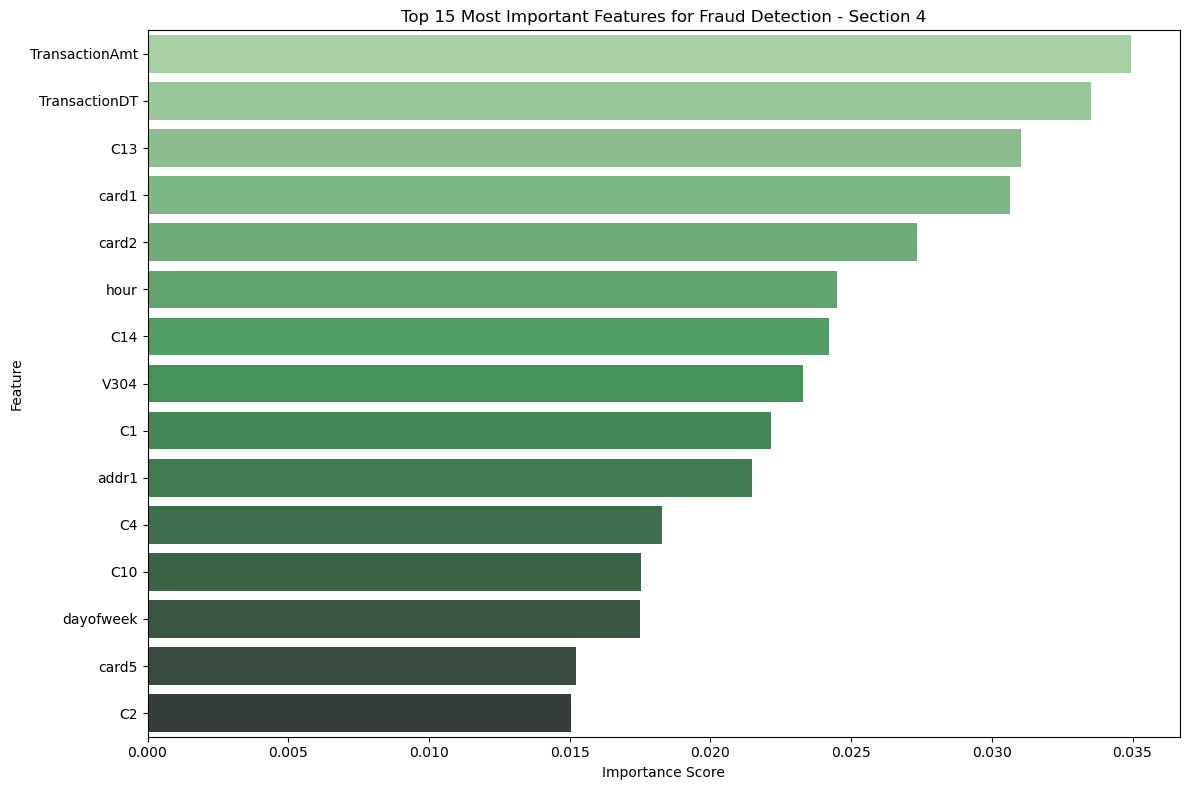

Top Features - Section 4:
             feature  importance
1    TransactionAmt    0.034939
0     TransactionDT    0.033522
20              C13    0.031028
2             card1    0.030630
3             card2    0.027358
177            hour    0.024512
21              C14    0.024219
158            V304    0.023295
8                C1    0.022169
6             addr1    0.021492
11               C4    0.018276
17              C10    0.017546
176       dayofweek    0.017496
5             card5    0.015214
9                C2    0.015063


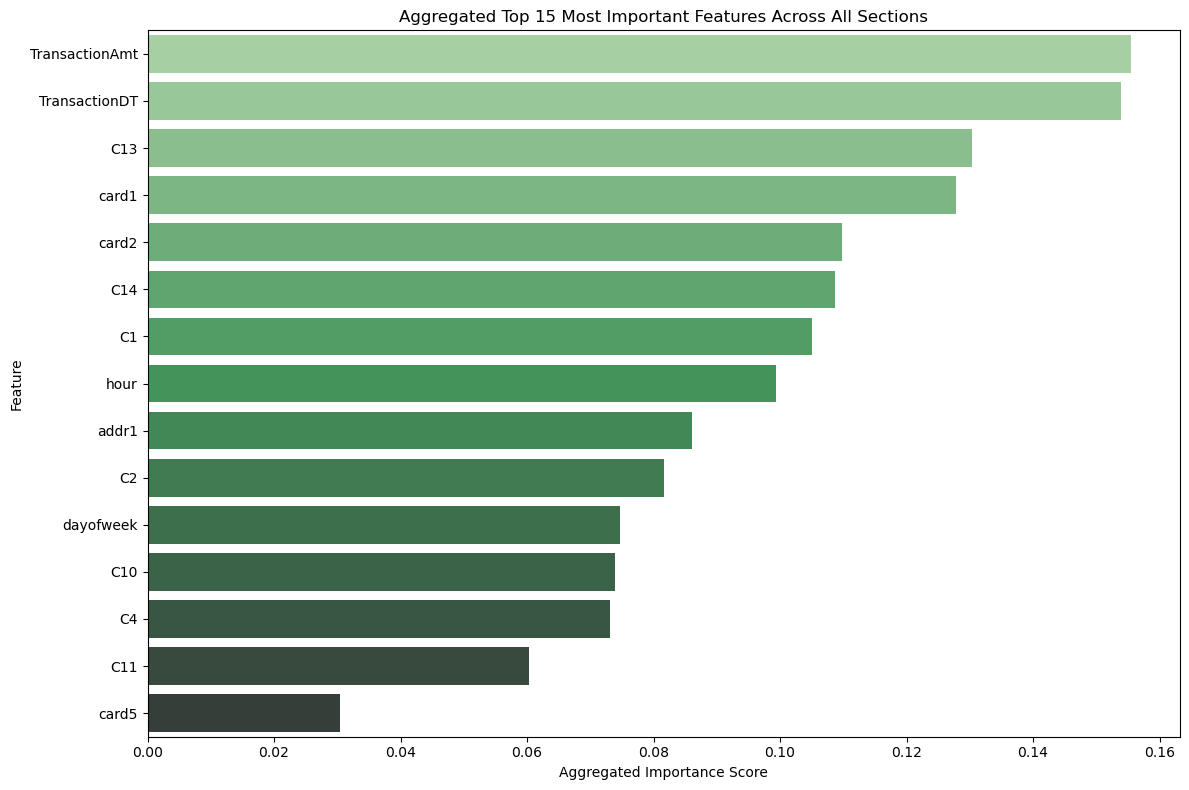


### Aggregated Top Features Across All Sections ###
           feature  importance
0   TransactionAmt    0.155454
1    TransactionDT    0.153926
3              C13    0.130364
2            card1    0.127846
4            card2    0.109812
7              C14    0.108747
6               C1    0.105090
8             hour    0.099433
9            addr1    0.086113
5               C2    0.081724
13       dayofweek    0.074710
11             C10    0.073959
14              C4    0.073147
10             C11    0.060345
16           card5    0.030449


In [11]:
import pandas as pd
import numpy as np
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# Function to split data into overlapping sections
def split_overlapping_sections(data, overlap=0.6, num_sections=4):
    """
    Splits data into overlapping sections.

    Parameters:
    - data (DataFrame): The dataset to split.
    - overlap (float): Fraction of overlap between consecutive sections (0 to <1).
    - num_sections (int): Total number of sections.

    Returns:
    - List of DataFrames, each representing a section.
    """
    if not (0 <= overlap < 1):
        raise ValueError("Overlap must be between 0 and 1 (exclusive).")

    total_rows = len(data)
    step_size = int(total_rows / (num_sections + (num_sections - 1) * overlap))
    sections = []

    for i in range(num_sections):
        start = int(i * step_size * (1 - overlap))
        end = start + step_size
        sections.append(data.iloc[start:end])

    return sections


# Prepare the dataset
# Assuming 'train' is a DataFrame with 'isFraud' as the target column
y = train["isFraud"]
X = train.drop(columns=["isFraud", "TransactionID"])

# Step 1: Filter out columns with >25% missing values
missing_percentages = X.isnull().mean() * 100
X_filtered = X.loc[
    :, missing_percentages <= 25
].copy()  # Use `.copy()` to prevent warnings

# Step 2: Impute missing values before encoding
for column in X_filtered.columns:
    if X_filtered[column].dtype in ["float64", "int64"]:  # Continuous variables
        X_filtered.loc[:, column] = X_filtered[column].fillna(
            X_filtered[column].median()
        )
    else:  # Categorical variables
        X_filtered.loc[:, column] = X_filtered[column].fillna(
            X_filtered[column].mode()[0]
        )

# Step 3: Encode categorical features
X_encoded = pd.get_dummies(X_filtered, drop_first=True)

# Combine X_encoded and y for splitting into sections
data_combined = pd.concat([X_encoded, y], axis=1)

# Split the dataset into 4 sections with 60% overlap
sections = split_overlapping_sections(data_combined, overlap=0.6, num_sections=4)

# Dictionary to aggregate feature importances across sections
aggregated_feature_importances = Counter()

# Process each section
for i, section in enumerate(sections):
    print(f"\n### Processing Section {i + 1} ###")

    # Separate features and target for the current section
    X_section = section.drop(columns=["isFraud"])
    y_section = section["isFraud"]

    # Step 4: Split the data for training (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X_section, y_section, test_size=0.2, random_state=42
    )

    # Step 5: Train a Balanced Random Forest model
    brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
    brf.fit(X_train, y_train)

    # Step 6: Evaluate the model
    y_pred = brf.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, brf.predict_proba(X_test)[:, 1]))

    # Visualize feature importance with the new template
    brf_feature_importances = pd.DataFrame(
        {"feature": X_train.columns, "importance": brf.feature_importances_}
    ).sort_values(by="importance", ascending=False)

    # Extract the top 15 features
    rf_top_features = brf_feature_importances.head(15)
    top_features_names = rf_top_features["feature"].tolist()

    # Add top features to the aggregated dictionary
    for feature, importance in zip(
        rf_top_features["feature"], rf_top_features["importance"]
    ):
        aggregated_feature_importances[feature] += importance

    # Plot the top 15 features for this section
    plt.figure(figsize=(12, 8))
    sns.barplot(data=rf_top_features, y="feature", x="importance", palette="Greens_d")
    plt.yticks(ticks=range(len(top_features_names)), labels=top_features_names)
    plt.title(f"Top 15 Most Important Features for Fraud Detection - Section {i + 1}")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # Store top features for this section (optional)
    print(f"Top Features - Section {i + 1}:\n", rf_top_features)

# Aggregate feature importances across all sections
aggregated_features_df = (
    pd.DataFrame.from_dict(
        aggregated_feature_importances, orient="index", columns=["importance"]
    )
    .reset_index()
    .rename(columns={"index": "feature"})
    .sort_values(by="importance", ascending=False)
)

# Extract top 15 features across all sections
aggregated_top_features = aggregated_features_df.head(15)
top_aggregated_feature_names = aggregated_top_features["feature"].tolist()

# Plot the aggregated top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(
    data=aggregated_top_features, y="feature", x="importance", palette="Greens_d"
)
plt.yticks(
    ticks=range(len(top_aggregated_feature_names)), labels=top_aggregated_feature_names
)
plt.title("Aggregated Top 15 Most Important Features Across All Sections")
plt.xlabel("Aggregated Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("\n### Aggregated Top Features Across All Sections ###")
print(aggregated_top_features)

# Sensitivity Analysis

            Feature  Baseline AUC  Perturbed AUC  AUC Change
176       dayofweek      0.912309       0.912227    0.000082
9                C2      0.912309       0.912242    0.000067
172            V318      0.912309       0.912268    0.000042
8                C1      0.912309       0.912278    0.000031
77              V82      0.912309       0.912288    0.000021
..              ...           ...            ...         ...
91              V96      0.912309       0.912340   -0.000031
13               C6      0.912309       0.912344   -0.000034
20              C13      0.912309       0.912348   -0.000039
177            hour      0.912309       0.912407   -0.000098
1    TransactionAmt      0.912309       0.912409   -0.000099

[246 rows x 4 columns]


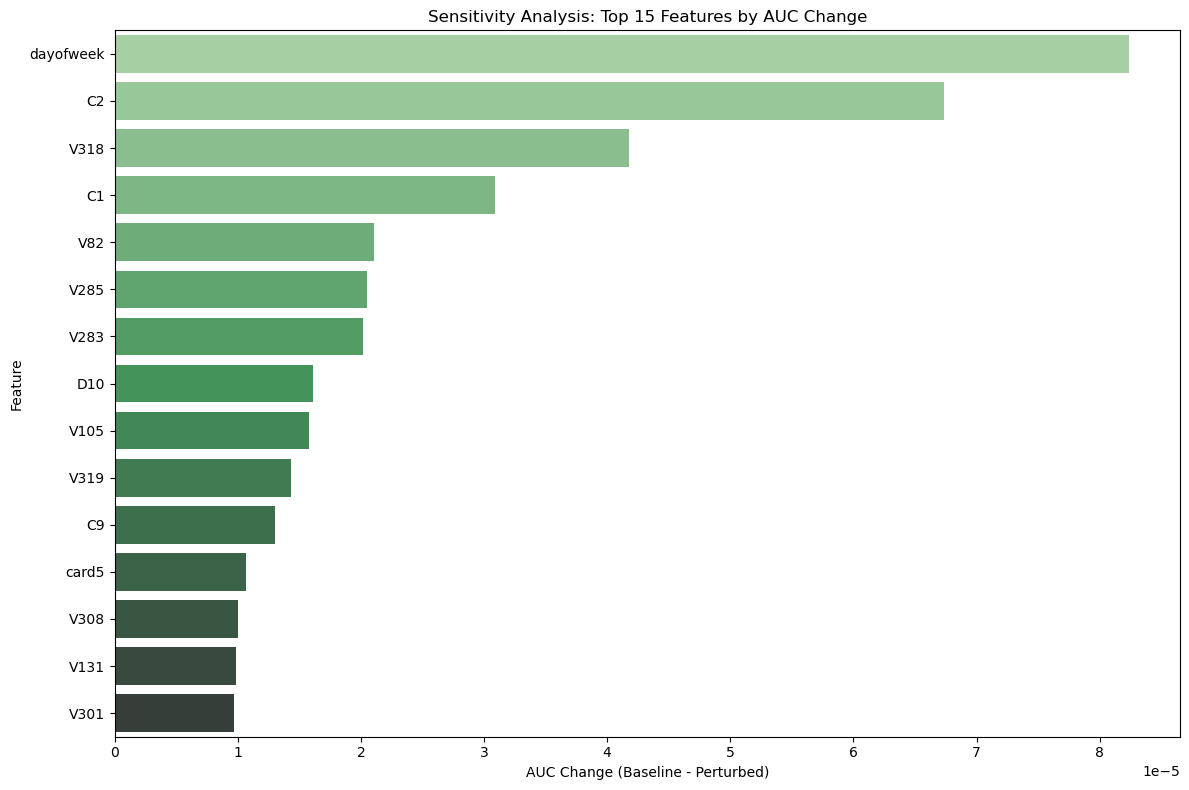

In [12]:
import numpy as np
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def sensitivity_analysis(
    model, X_test, y_test, perturbation="noise", perturbation_scale=0.1
):
    """
    Conducts sensitivity analysis by perturbing features in the test set.

    Parameters:
    - model: The trained model (e.g., BalancedRandomForestClassifier).
    - X_test: Test features (DataFrame).
    - y_test: True labels for the test set.
    - perturbation: Type of perturbation ("noise", "mean", or "zero").
    - perturbation_scale: Scale of noise to add (for "noise" perturbation).

    Returns:
    - results: DataFrame with sensitivity metrics for each feature.
    """
    # Baseline performance
    baseline_predictions = model.predict_proba(X_test)[:, 1]
    baseline_auc = roc_auc_score(y_test, baseline_predictions)

    sensitivity_results = []

    # Iterate through each feature in the test set
    for feature in X_test.columns:
        perturbed_X = X_test.copy()

        # Apply perturbation
        if perturbation == "noise":
            # Add random noise to the feature
            noise = np.random.normal(0, perturbation_scale, size=len(X_test))
            perturbed_X[feature] += noise
        elif perturbation == "mean":
            # Replace feature with its mean
            perturbed_X[feature] = X_test[feature].mean()
        elif perturbation == "zero":
            # Set feature to zero
            perturbed_X[feature] = 0
        else:
            raise ValueError(
                "Unsupported perturbation type. Use 'noise', 'mean', or 'zero'."
            )

        # Make predictions with the perturbed data
        perturbed_predictions = model.predict_proba(perturbed_X)[:, 1]
        perturbed_auc = roc_auc_score(y_test, perturbed_predictions)

        # Calculate change in AUC
        auc_change = baseline_auc - perturbed_auc

        # Store results
        sensitivity_results.append(
            {
                "Feature": feature,
                "Baseline AUC": baseline_auc,
                "Perturbed AUC": perturbed_auc,
                "AUC Change": auc_change,
            }
        )

    # Convert results to DataFrame
    results_df = pd.DataFrame(sensitivity_results).sort_values(
        by="AUC Change", ascending=False
    )
    return results_df


# Perform sensitivity analysis
sensitivity_results = sensitivity_analysis(
    model=brf,
    X_test=X_test,
    y_test=y_test,
    perturbation="noise",  # Options: "noise", "mean", "zero"
    perturbation_scale=0.1,
)

# Display results
print(sensitivity_results)

# Visualize sensitivity results with green palette
plt.figure(figsize=(12, 8))
sns.barplot(
    x="AUC Change",
    y="Feature",
    data=sensitivity_results.head(15),  # Top 15 features
    palette="Greens_d",
    order=sensitivity_results.head(15)["Feature"],
)
plt.title("Sensitivity Analysis: Top 15 Features by AUC Change")
plt.xlabel("AUC Change (Baseline - Perturbed)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# SHAP - Shapely Additive exPlanations

Couldn't get anything to work

# ALE and PD Plots


### PD Plots


### Generating Optimized PDP Plots ###


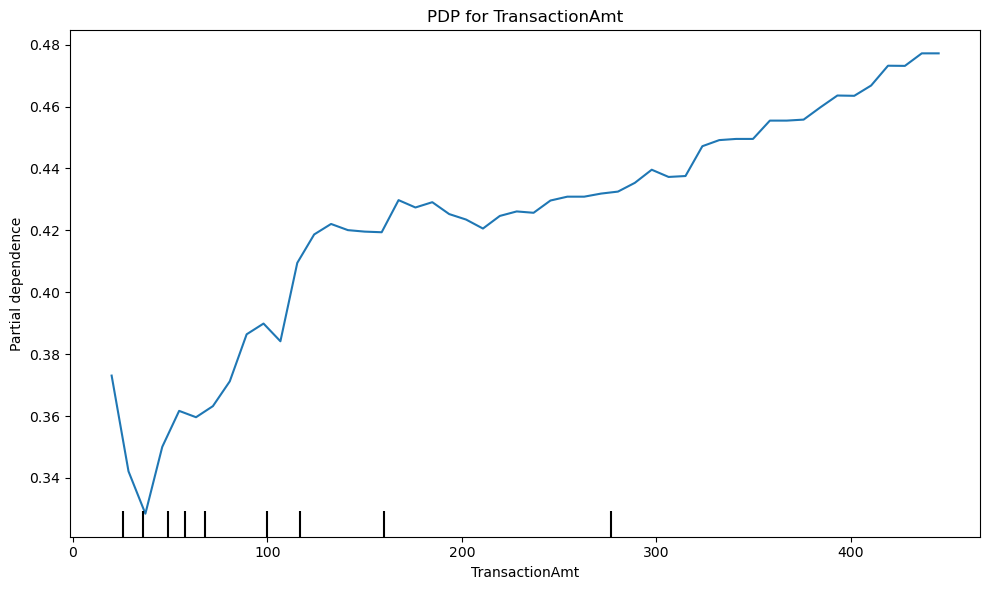

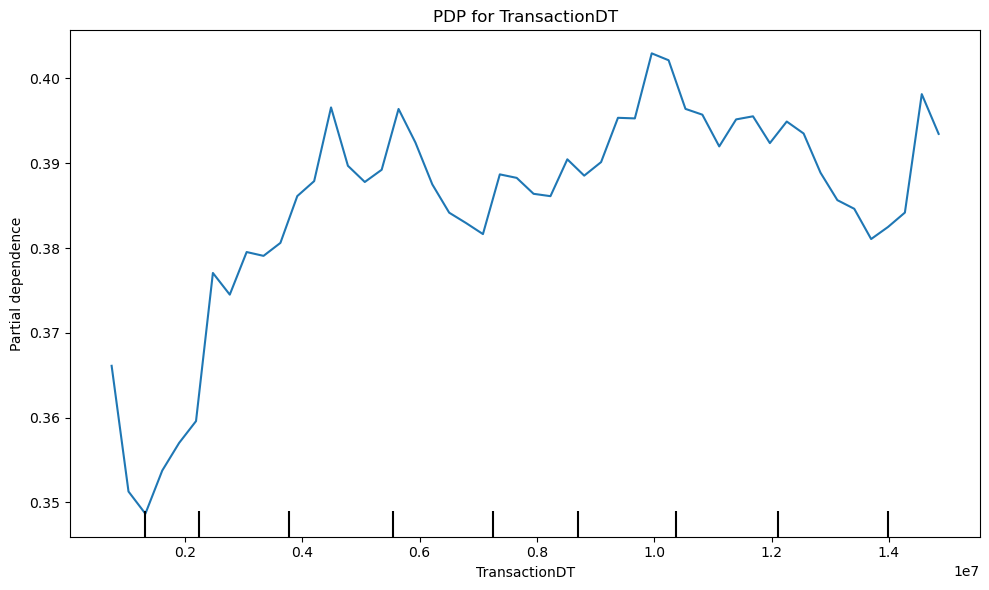

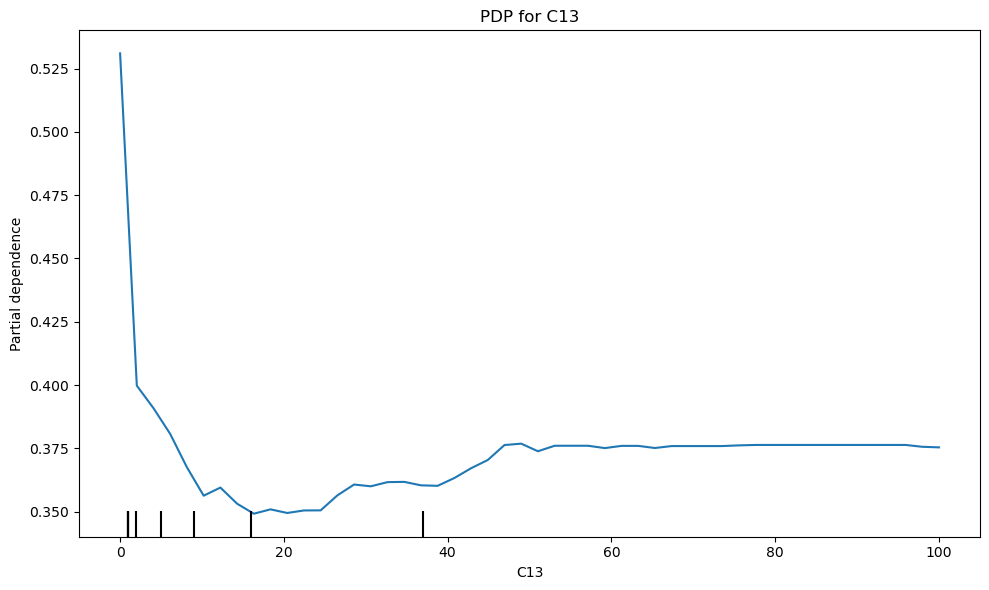

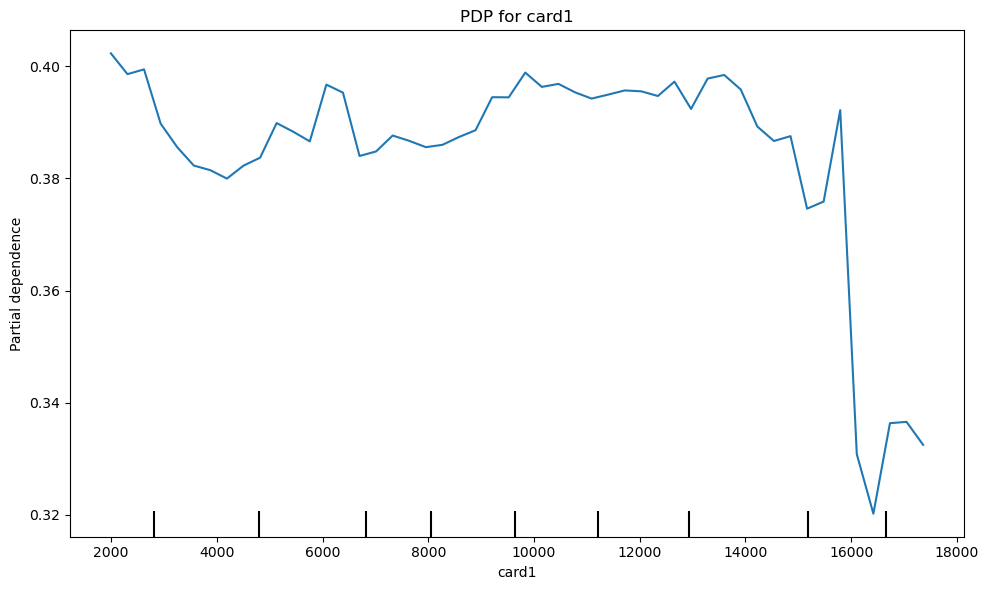

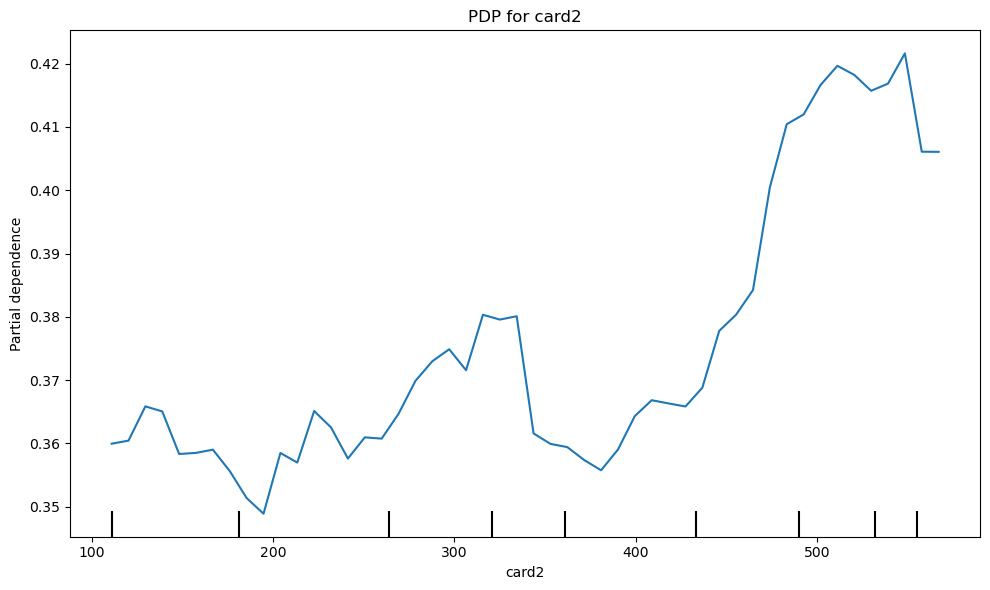

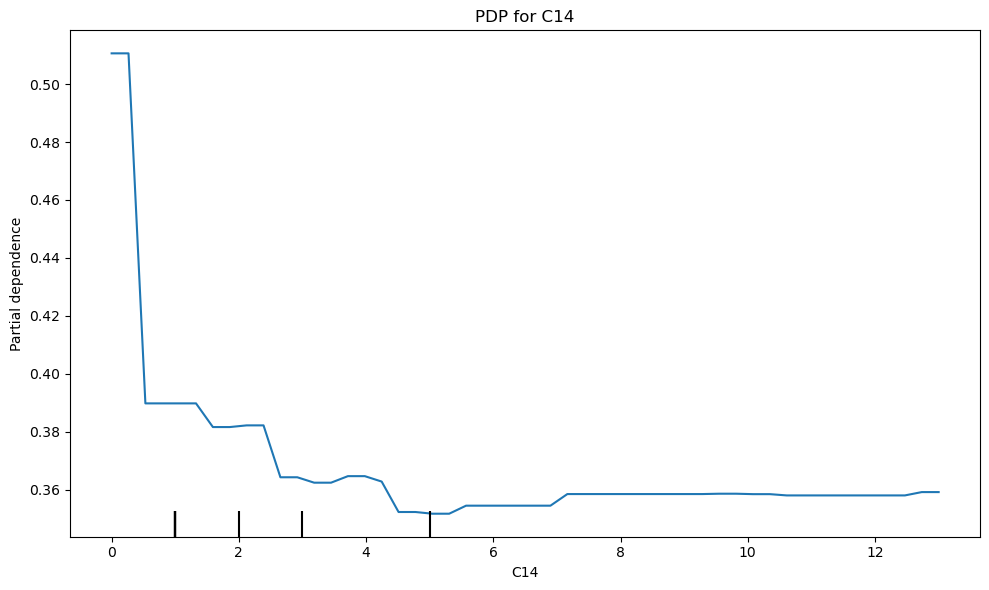

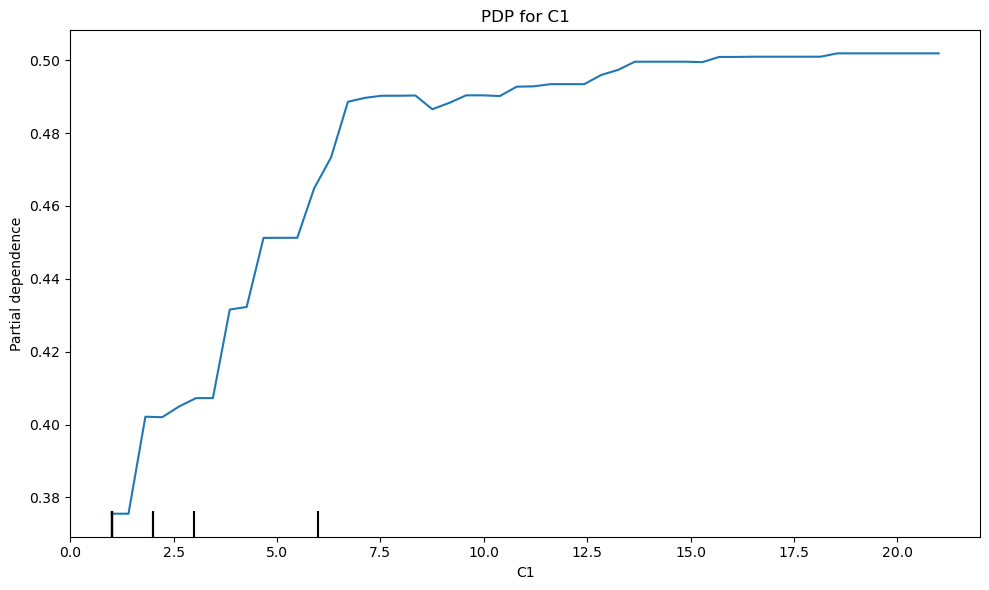

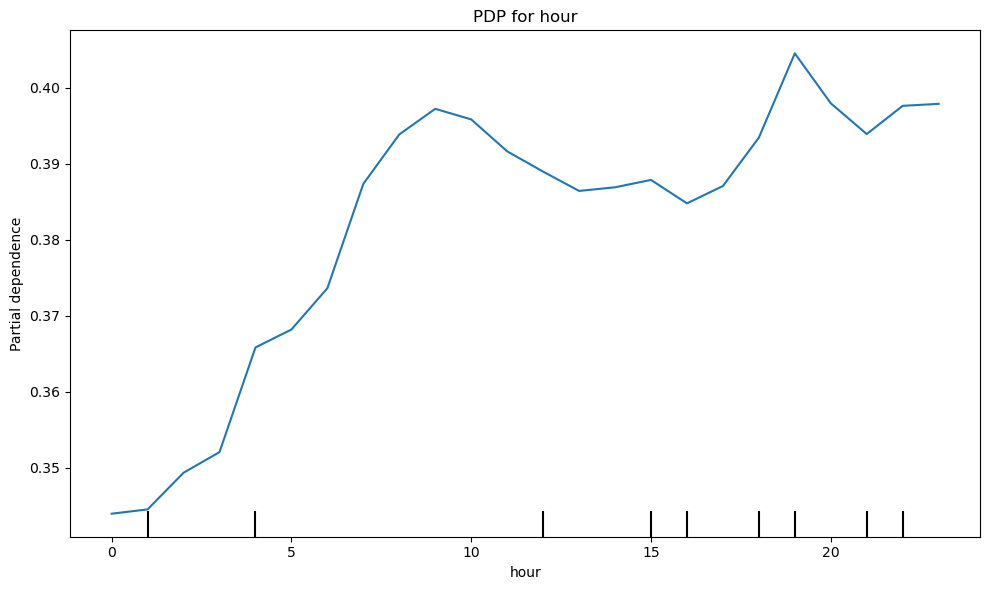

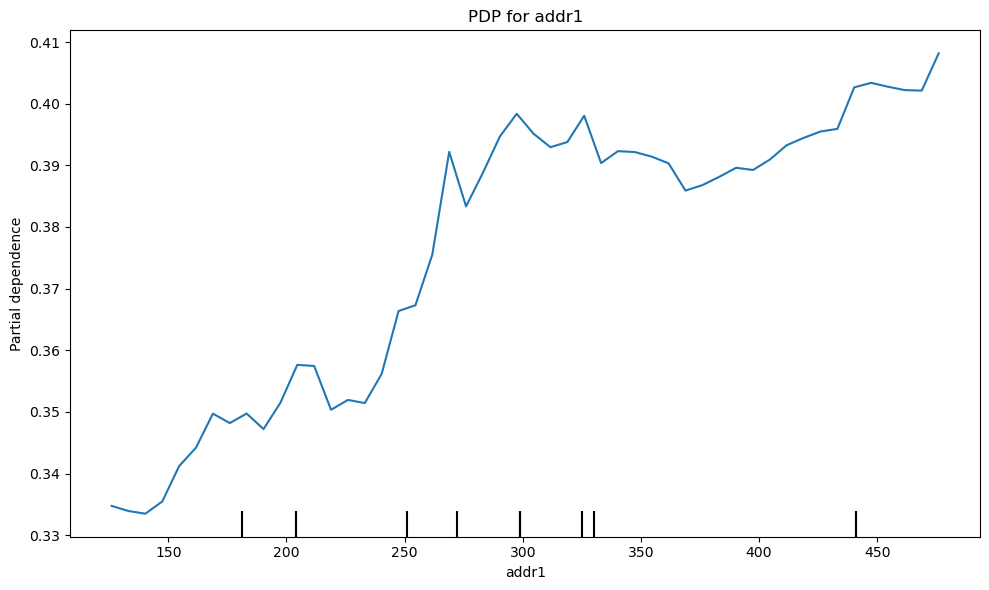

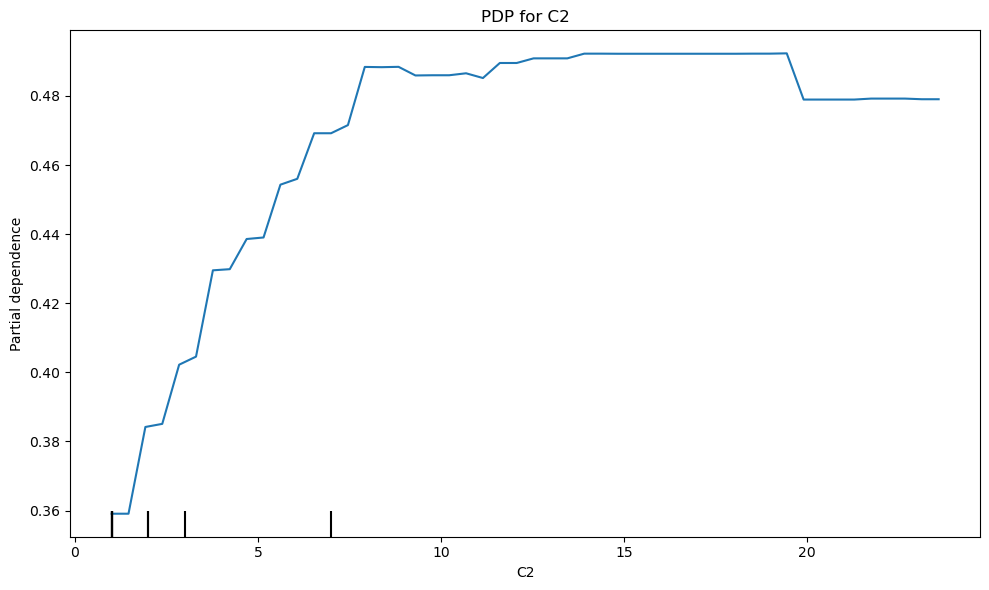

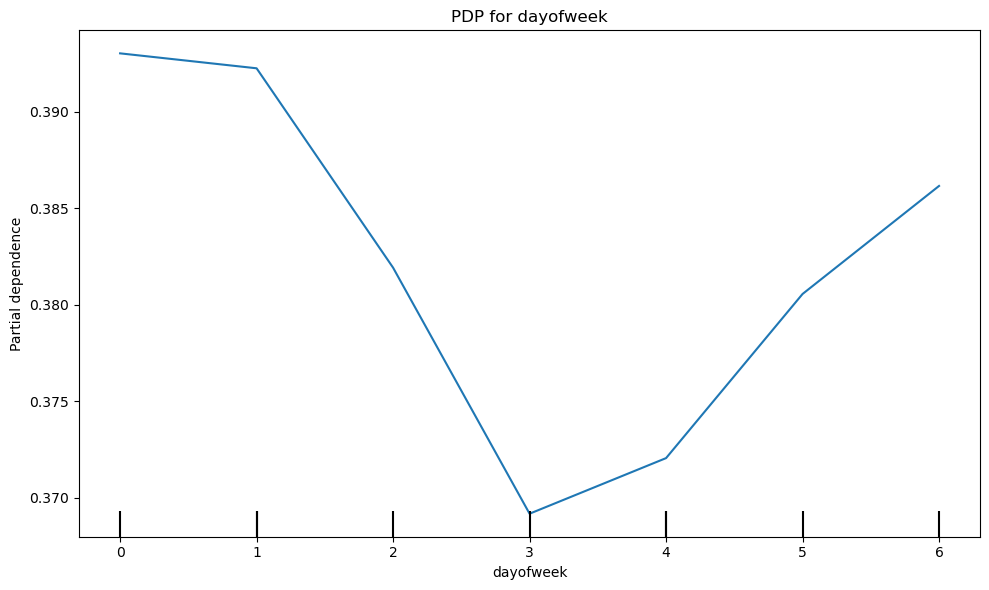

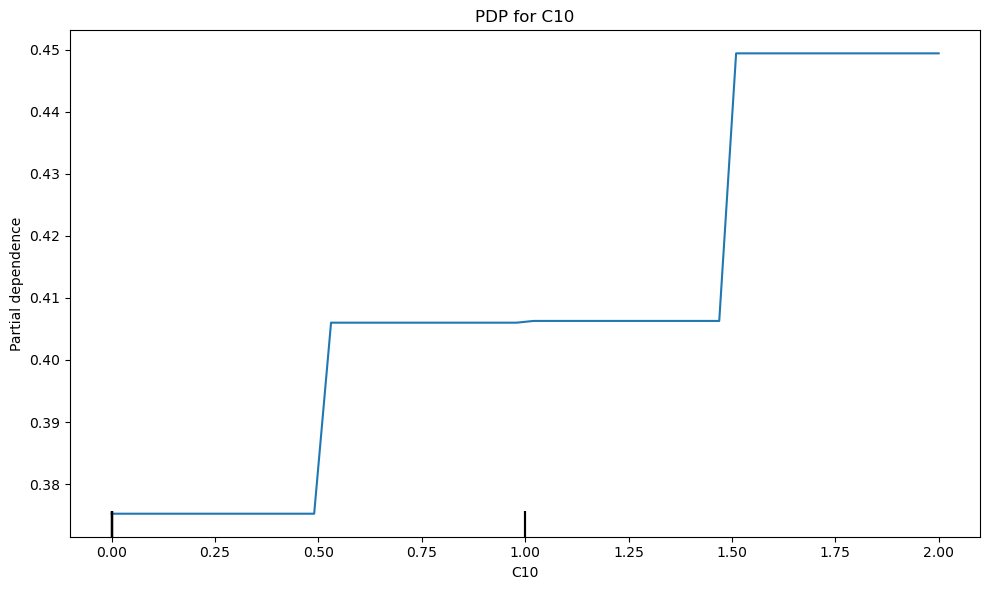

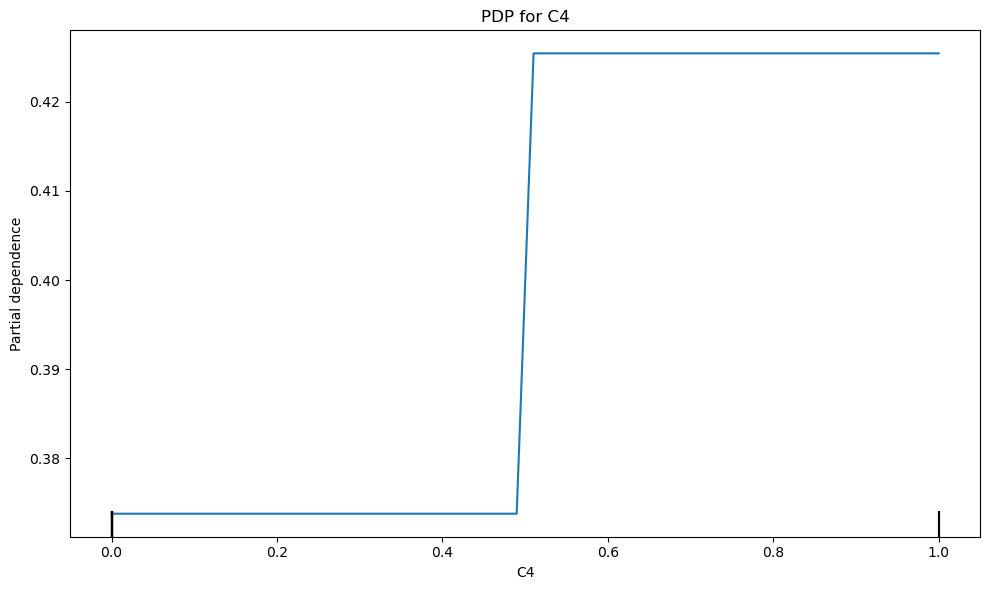

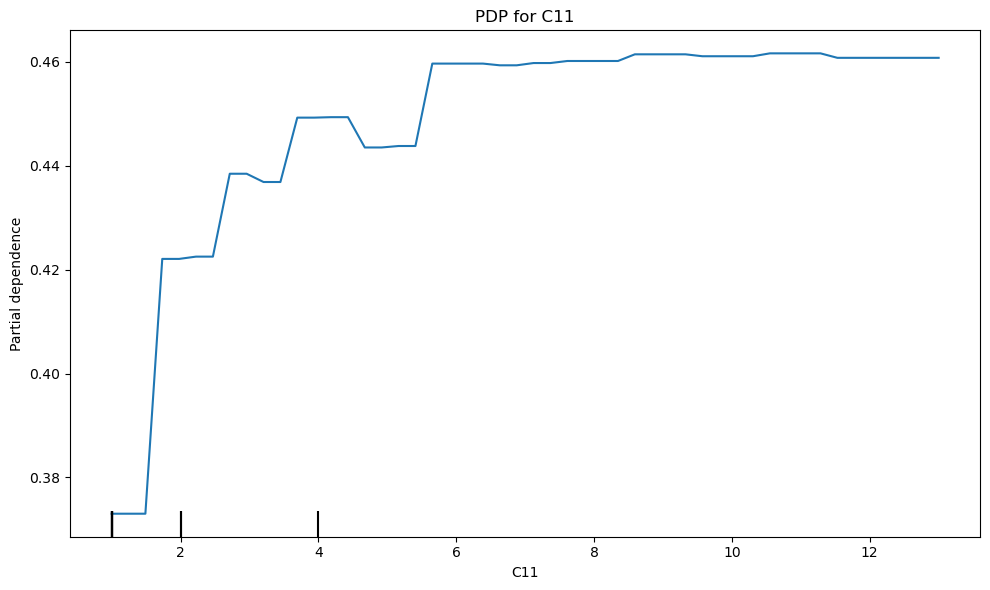

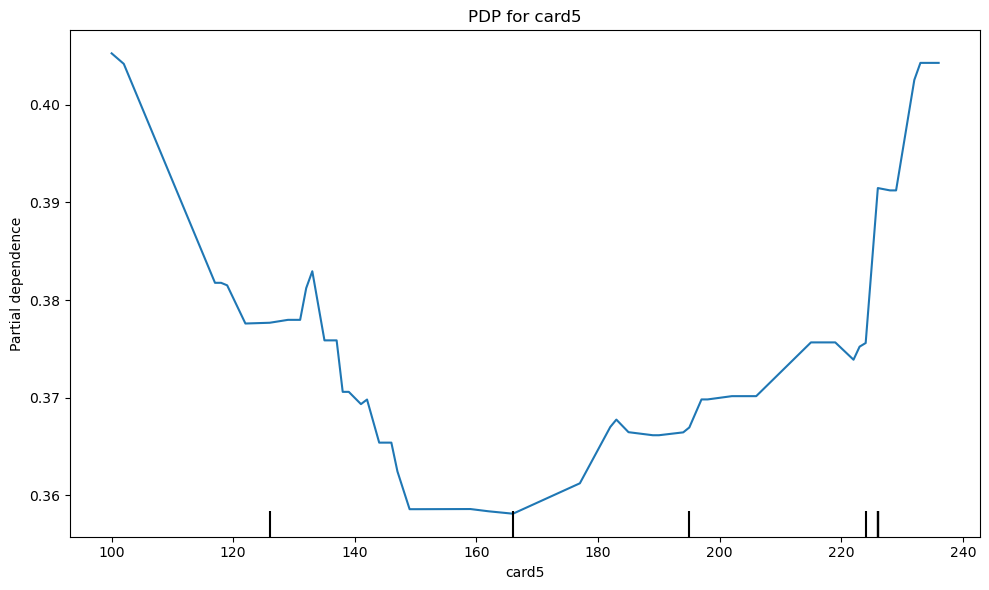

In [13]:
from sklearn.inspection import PartialDependenceDisplay
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Subset the train dataset to include only the top aggregated features
X_train_subset = X_encoded[top_aggregated_feature_names]
y_train_subset = y

# Use a sample of the dataset for faster computation
X_sampled = X_train_subset.sample(n=10000, random_state=42)  # Sample 10,000 rows
y_sampled = y_train_subset.loc[X_sampled.index]  # Align sampled labels

# Train the Balanced Random Forest model on the subset of data
brf_subset = BalancedRandomForestClassifier(n_estimators=50, random_state=42)
brf_subset.fit(X_sampled, y_sampled)

# Generate PDP plots for the top aggregated features
print("\n### Generating Optimized PDP Plots ###")
for feature in top_aggregated_feature_names:
    if feature in X_sampled.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        PartialDependenceDisplay.from_estimator(
            estimator=brf_subset,
            X=X_sampled,
            features=[feature],
            ax=ax,
            kind="average",
            grid_resolution=50,  # Reduce number of grid points
            n_jobs=-1,  # Enable parallel computation
        )
        plt.title(f"PDP for {feature}")
        plt.tight_layout()
        plt.show()

### ALE Plots


### Generating ALE Plots for Top Aggregated Features ###


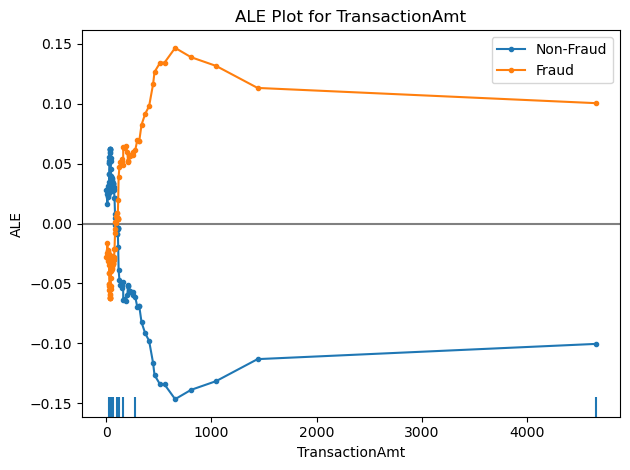

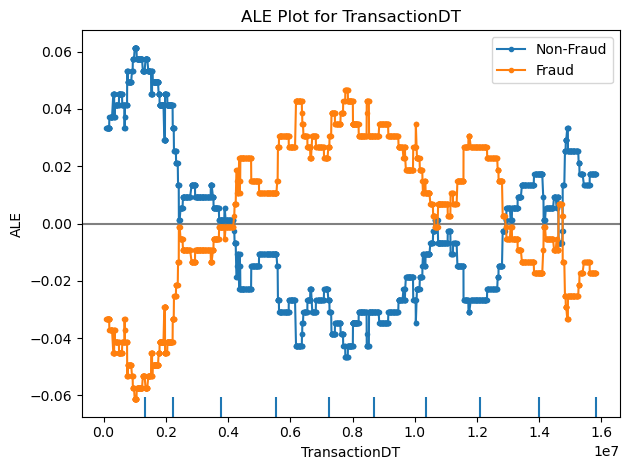

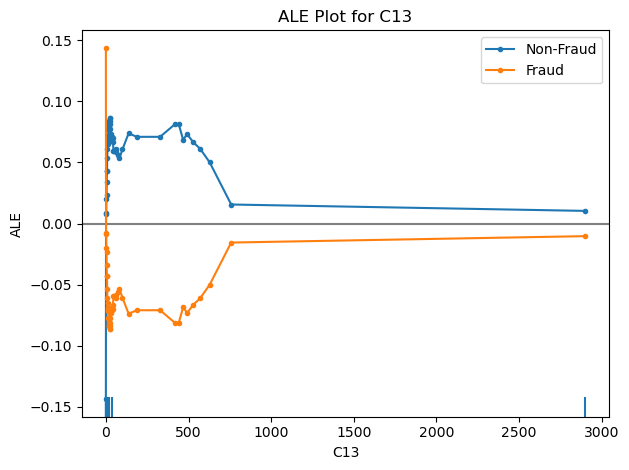

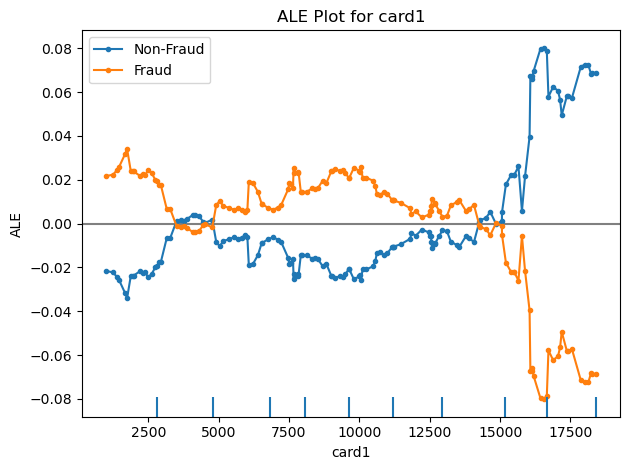

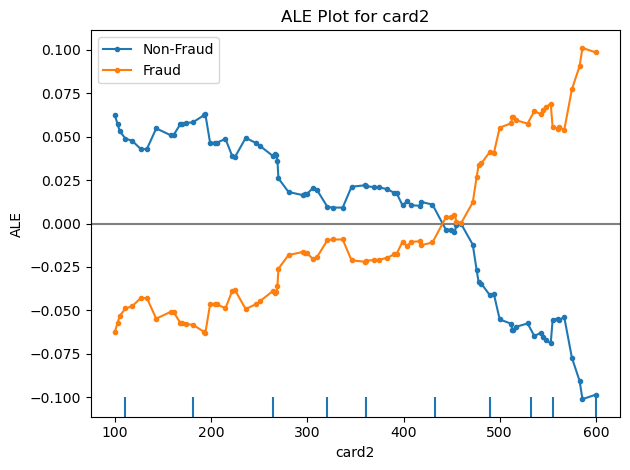

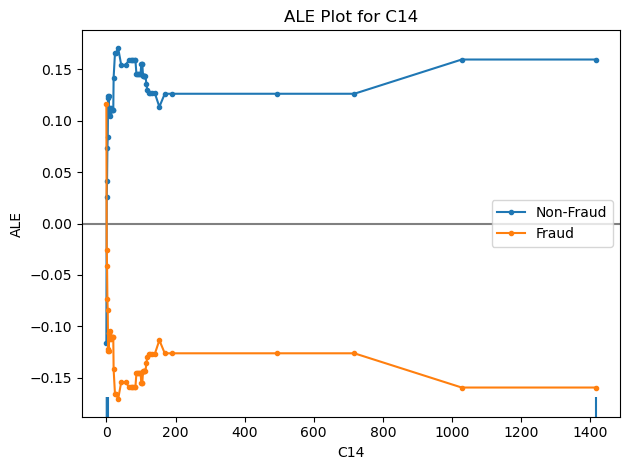

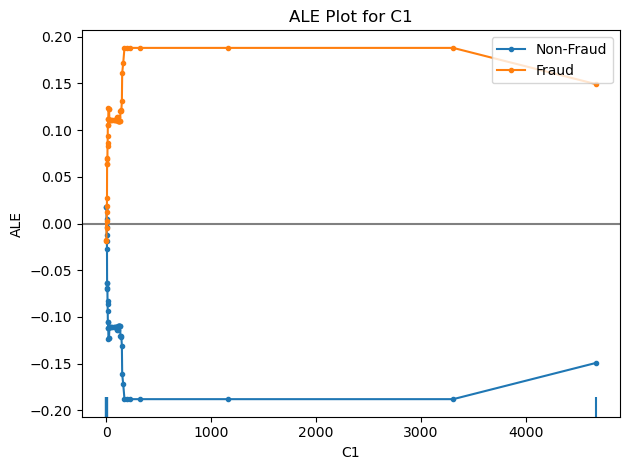

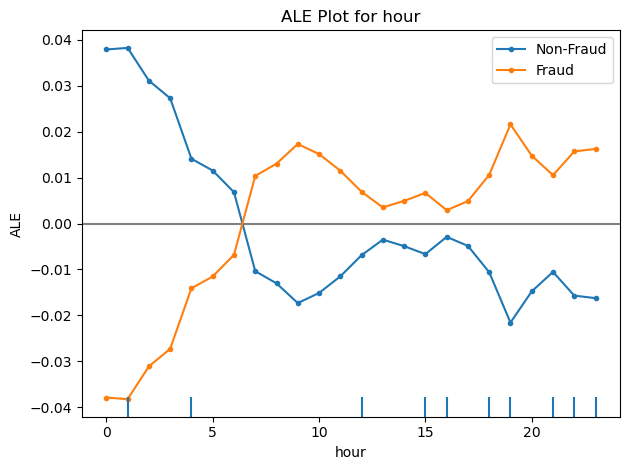

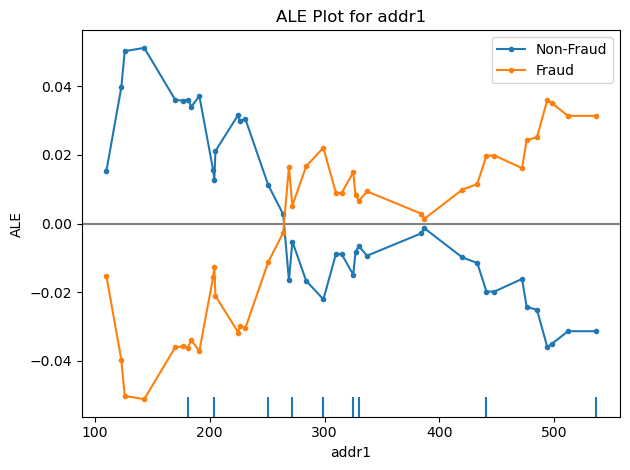

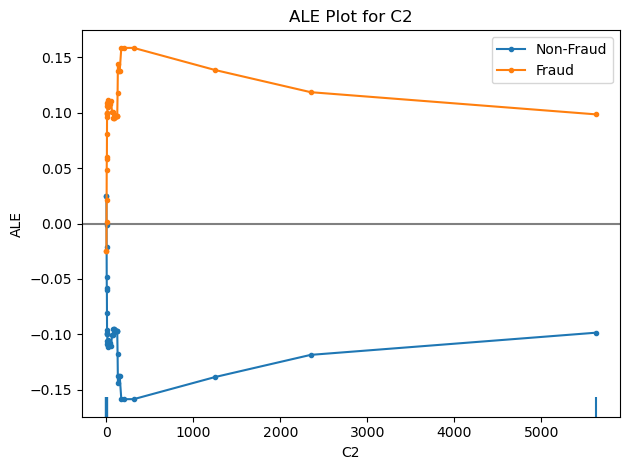

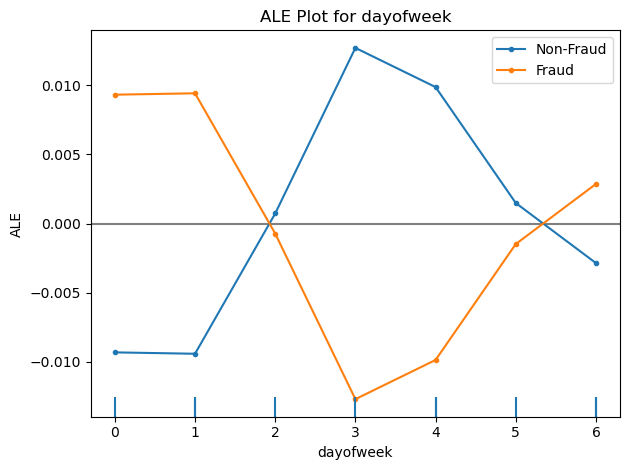

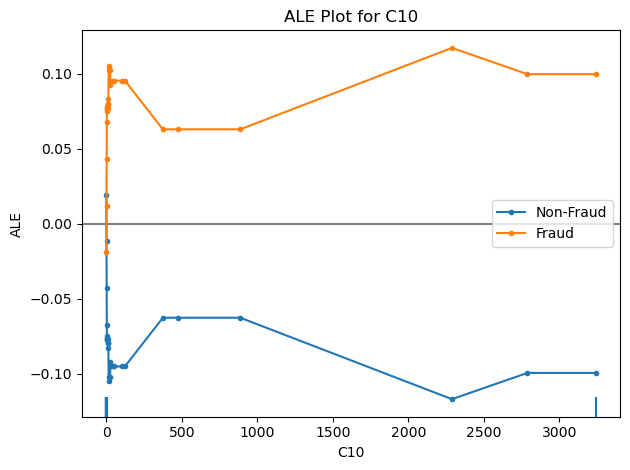

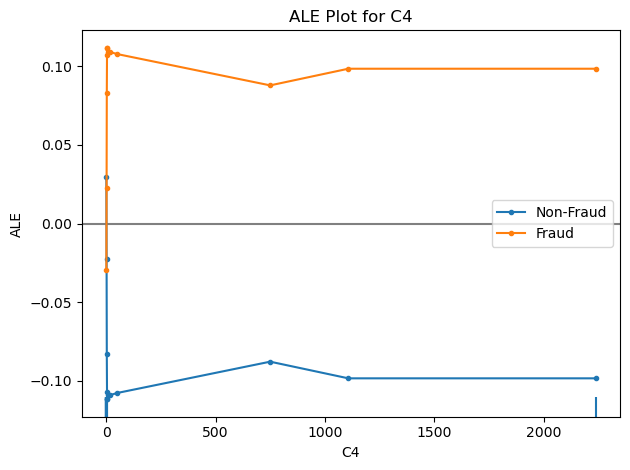

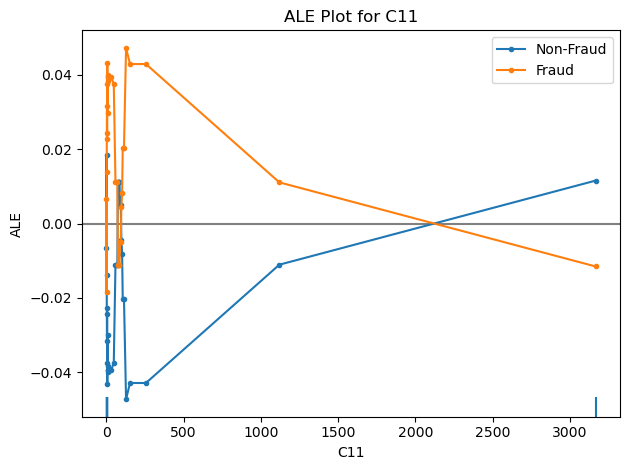

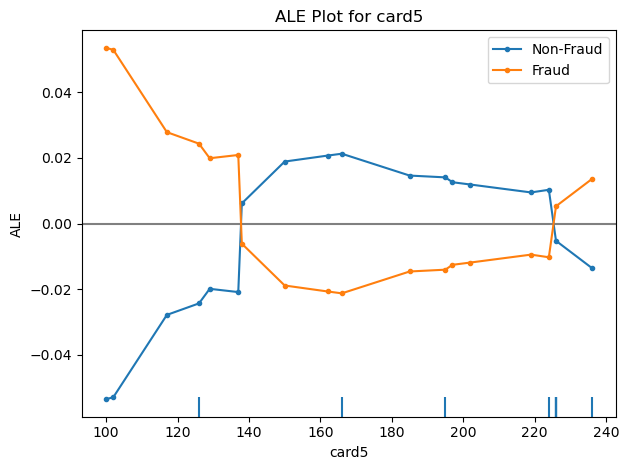

In [14]:
from alibi.explainers import ALE
from alibi.explainers.ale import plot_ale
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Subset the train dataset to include only the top aggregated features
X_train_subset = X_encoded[top_aggregated_feature_names]
y_train_subset = y

# Ensure there are no alignment issues
X_train_subset, y_train_subset = X_train_subset.align(y_train_subset, axis=0)

# Step 2: Sample the dataset for faster ALE computation
sample_size = min(10000, len(X_train_subset))  # Limit sample size to available data
X_sampled = X_train_subset.sample(n=sample_size, random_state=42)
y_sampled = y_train_subset.loc[X_sampled.index]

# Step 3: Train the Balanced Random Forest model on the sampled data
brf_subset = BalancedRandomForestClassifier(
    n_estimators=50, random_state=42
)  # Fewer trees for faster training
brf_subset.fit(X_sampled, y_sampled)


# Step 4: Use a wrapper function for predictions to include valid feature names
def wrapped_predict_proba(X):
    """
    Ensure predictions are made with valid feature names.
    """
    if isinstance(X, np.ndarray):  # If input is a NumPy array
        X = pd.DataFrame(X, columns=X_sampled.columns)  # Convert back to DataFrame
    return brf_subset.predict_proba(X)


# Initialize ALE Explainer
ale_explainer = ALE(
    predictor=wrapped_predict_proba,  # Wrapped function ensures feature names are used
    feature_names=X_sampled.columns.tolist(),  # Feature names for ALE plots
    target_names=["Non-Fraud", "Fraud"],
)

# Step 5: Compute ALE on the sampled data
ale_result = ale_explainer.explain(
    X_sampled.to_numpy()
)  # Use NumPy array for ALE computation

# Step 6: Plot ALE for each top feature
print("\n### Generating ALE Plots for Top Aggregated Features ###")
for feature_idx, feature_name in enumerate(X_sampled.columns):
    try:
        plot_ale(ale_result, features=[feature_idx])
        plt.title(f"ALE Plot for {feature_name}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating ALE plot for feature '{feature_name}': {e}")

# WORK ABOVE THESE CELLS  -ALL CODE BELOW IS COMMENTED OUT

# Keep code block below - OG balanced classifier

In [16]:
# import pandas as pd

# from imblearn.ensemble import BalancedRandomForestClassifier

# from sklearn.model_selection import train_test_split

# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# import matplotlib.pyplot as plt

# import seaborn as sns


# # Separate target and drop 'TransactionID' column

# y = train["isFraud"]

# X = train.drop(columns=["isFraud", "TransactionID"])


# # Step 1: Filter out columns with >25% missing values

# missing_percentages = X.isnull().mean() * 100

# X_filtered = X.loc[:, missing_percentages <= 25]


# # Step 2: Impute missing values before encoding

# for column in X_filtered.columns:

#     if X_filtered[column].dtype in ["float64", "int64"]:  # Continuous variables

#         X_filtered[column] = X_filtered[column].fillna(X_filtered[column].median())

#     else:  # Categorical variables

#         X_filtered[column] = X_filtered[column].fillna(X_filtered[column].mode()[0])


# # Step 3: Encode categorical features

# X_encoded = pd.get_dummies(X_filtered, drop_first=True)


# # Step 4: Split the data for training (80% train, 20% test)

# X_train, X_test, y_train, y_test = train_test_split(
#     X_encoded, y, test_size=0.2, random_state=42
# )


# # Step 5: Train a Balanced Random Forest model

# brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

# brf.fit(X_train, y_train)


# # Step 6: Evaluate the model

# y_pred = brf.predict(X_test)

# print("Classification Report:\n", classification_report(y_test, y_pred))

# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# print("ROC AUC Score:", roc_auc_score(y_test, brf.predict_proba(X_test)[:, 1]))


# # Visualize feature importance

# brf_feature_importances = pd.DataFrame(
#     {"Feature": X_train.columns, "Importance": brf.feature_importances_}
# ).sort_values(by="Importance", ascending=False)


# plt.figure(figsize=(10, 8))

# sns.barplot(x="Importance", y="Feature", data=brf_feature_importances.head(15))

# plt.title("Top 15 Feature Importances")

# plt.tight_layout()

# plt.show()


# brf_top_features = brf_feature_importances.head(15)

In [17]:
# print("Random Forest Features (Structure):", rf_top_features[:5])

# print("Balanced Random Forest Features (Structure):", brf_top_features[:5])

In [18]:
# # Convert the 'feature' or 'Feature' column into sets

# rf_features_set = set(rf_top_features["feature"])  # Random Forest

# brf_features_set = set(brf_top_features["Feature"])  # Balanced Random Forest


# # Find common and unique features

# common_features = rf_features_set & brf_features_set

# rf_unique = rf_features_set - brf_features_set

# brf_unique = brf_features_set - rf_features_set


# # Print the results

# print("Common Features:", common_features)

# print("Features Unique to Random Forest:", rf_unique)

# print("Features Unique to Balanced Random Forest:", brf_unique)

In [19]:
# # Convert feature importance to dictionaries for easy alignment

# rf_importances = dict(zip(rf_top_features["feature"], rf_top_features["importance"]))

# brf_importances = dict(zip(brf_top_features["Feature"], brf_top_features["Importance"]))


# # Combine all features

# all_features = rf_features_set | brf_features_set


# # Align importance values, using 0 if a feature is not present in one of the models

# rf_values = [rf_importances.get(feature, 0) for feature in all_features]

# brf_values = [brf_importances.get(feature, 0) for feature in all_features]


# # Print comparison

# for feature, rf_value, brf_value in zip(all_features, rf_values, brf_values):

#     print(
#         f"Feature: {feature}, RF Importance: {rf_value:.6f}, BRF Importance: {brf_value:.6f}"
#     )


# import matplotlib.pyplot as plt

# import numpy as np


# # Prepare for plotting

# features = list(all_features)

# indices = np.arange(len(features))


# plt.figure(figsize=(12, 6))

# plt.bar(indices - 0.2, rf_values, width=0.4, label="Random Forest")

# plt.bar(indices + 0.2, brf_values, width=0.4, label="Balanced Random Forest")


# plt.xticks(indices, features, rotation=90)

# plt.ylabel("Feature Importance")

# plt.title("Feature Importance Comparison: RF vs BRF")

# plt.legend()

# plt.tight_layout()

# plt.show()

Split data and scale. 

In [20]:
# # Separate features and target

# X = credit_card_data.drop("Class", axis=1)

# y = credit_card_data["Class"]


# # Split the dataset

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )


# # Scale features

# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train)

# X_test_scaled = scaler.transform(X_test)

The block below can take longer than 5 mins to run depending on you computer specs.

In [21]:
# # Function to evaluate models


# def evaluate_model(model, X_train, y_train, X_test, y_test):

#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)

#     print(
#         f"{model.__class__.__name__} Classification Report:\n",
#         classification_report(y_test, y_pred),
#     )

#     print(
#         f"{model.__class__.__name__} ROC AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}\n"
#     )


# # Logistic Regression

# logistic_model = LogisticRegression()

# evaluate_model(logistic_model, X_train_scaled, y_train, X_test_scaled, y_test)


# # Decision Tree

# dtree_model = DecisionTreeClassifier()

# evaluate_model(dtree_model, X_train, y_train, X_test, y_test)


# # Random Forest with parallel processing and fewer estimators

# rforest_model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

# evaluate_model(rforest_model, X_train, y_train, X_test, y_test)


# # # Gradient Boosting with fewer estimators

# gboost_model = GradientBoostingClassifier(n_estimators=50)

# evaluate_model(gboost_model, X_train, y_train, X_test, y_test)


# # XGBoost with fewer estimators and parallel processing

# xgb_model = XGBClassifier(
#     n_estimators=50, eval_metric="logloss", n_jobs=-1, random_state=42
# )

# evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

In [22]:
# # Define a function to store performance metrics for each model


# def evaluate_model_performance(model, X_train, y_train, X_test, y_test):

#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)

#     report = classification_report(y_test, y_pred, output_dict=True)

#     # Check if the model supports predict_proba

#     if hasattr(model, "predict_proba"):

#         auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

#     else:

#         auc_score = (
#             None  # Or use a default score like 0.5 if predict_proba is not available
#         )

#     f1_score = report["weighted avg"]["f1-score"]

#     return auc_score, f1_score


# # Define models


# models = {
#     "Logistic Regression": LogisticRegression(),
#     "Decision Tree": DecisionTreeClassifier(),
#     "Random Forest": RandomForestClassifier(),
#     "Gradient Boosting": GradientBoostingClassifier(),
#     "XGBoost": XGBClassifier(eval_metric="logloss"),
# }


# # Initialize lists to store results


# auc_scores = []


# f1_scores = []


# model_names = []


# # Evaluate each model


# for name, model in models.items():

#     auc, f1 = evaluate_model_performance(
#         model, X_train_scaled, y_train, X_test_scaled, y_test
#     )

#     auc_scores.append(auc)

#     f1_scores.append(f1)

#     model_names.append(name)


# # Store results in a DataFrame


# results = pd.DataFrame(
#     {"Model": model_names, "ROC AUC Score": auc_scores, "F1 Score": f1_scores}
# )


# # Plotting metrics


# metrics = {"ROC AUC Score": auc_scores, "F1 Score": f1_scores}


# for metric_name, scores in metrics.items():

#     plt.figure(figsize=(10, 5))

#     plt.plot(model_names, scores, marker="o", label=metric_name)

#     plt.xlabel("Model")

#     plt.ylabel(metric_name)

#     plt.title(f"Model {metric_name}")

#     plt.legend()

#     plt.grid(True)

#     plt.show()

# Attempt at ALE and Partial Dependence Plots

In [23]:
# # Verify column names match

# assert list(X_test.columns) == list(X_encoded.columns), "Column names do not match!"

In [24]:
# from alibi.explainers.ale import ALE, plot_ale

# import matplotlib.pyplot as plt


# # Map the original feature names to the top features

# selected_features = [
#     "TransactionDT",
#     "TransactionAmt",
#     "card1",
#     "C1",
#     "hour",
#     "card2",
#     "C13",
#     "addr1",
#     "C14",
#     "dayofweek",
#     "C2",
#     "C11",
#     "V87",
#     "C12",
#     "C6",
# ]


# top_features_names = [
#     "DateTime",
#     "Amount",
#     "transaction Type",
#     "Card Provider",
#     "transaction addrs",
#     "issue bank",
#     "card limit",
#     "avg transactions",
#     "card country",
#     "recency",
#     "avg amount",
#     "Enriched variable",
#     "debit_credit",
#     "days between transactions",
#     "numbers of address",
# ]


# # Create a copy of the test set and sample a smaller subset

# X_test_copy = X_test.copy()

# X_test_sample = X_test_copy.sample(10_000, random_state=42)  # Sample 2000 rows


# # Initialize ALE explainer with all features

# ale = ALE(lambda x: rf.predict_proba(x)[:, 1], feature_names=X_test.columns)


# # Compute ALE explanation on the sampled dataset

# ale_explanation = ale.explain(X_test_sample.values)


# # Plot ALE for the top 15 features

# for i, feature in enumerate(selected_features):

#     feature_idx = [list(X_test.columns).index(feature)]  # Make feature_idx a list

#     plot_ale(ale_explanation, features=feature_idx)  # Use plot_ale for visualization

#     plt.title(f"ALE Plot for {top_features_names[i]}")

#     plt.xlabel(top_features_names[i])

#     plt.ylabel("Effect on Prediction")

#     plt.tight_layout()

#     plt.show()

In [25]:
# from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# import matplotlib.pyplot as plt


# # Create a copy of the test set and sample a smaller subset

# X_test_copy = X_test.copy()

# X_test_sample = X_test_copy.sample(10_000, random_state=42)  # Use the same sampled data


# # Plot PDP for the top 15 features

# for i, feature in enumerate(selected_features):

#     feature_idx = list(X_test.columns).index(feature)  # Get the feature index

#     PartialDependenceDisplay.from_estimator(
#         rf,  # Random Forest model
#         X_test_sample,  # Sampled data
#         [feature_idx],  # Single feature
#         grid_resolution=50,  # Number of evaluation points
#     )

#     plt.title(f"PDP for {top_features_names[i]}")

#     plt.xlabel(top_features_names[i])

#     plt.ylabel("Effect on Prediction")

#     plt.tight_layout()

#     plt.show()